In [8]:
# SETUP
!pip install lancedb open_clip_torch arxiv --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=294e6b709120203187d4be5f4d77a118173b88d4feee49642595b3060423a544
  Stored in directory: /private/tmp/pip-ephem-wheel-cache-dyw0r0kc/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Explain Open CLIP and embeddings here

## Creating table from arxiv API

### Embedding Paper Summary using CLIP


In [1]:
import torch
import open_clip
import pandas as pd
from open_clip import tokenizer
from tqdm import tqdm
from collections import defaultdict
import arxiv
import lancedb

def embed_func_clip(text):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    with torch.no_grad():
        text_features = model.encode_text(tokenizer(text))
    return text_features

/Users/ayushchaurasia/Documents/vectordb-recipes/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a DataFrame of the desired length

In [2]:
def get_arxiv_df(embed_func, length=10000):
    results = arxiv.Search(
      query= "cat:cs.AI OR cat:cs.CV OR cat:stat.ML",
      max_results = length,
      sort_by = arxiv.SortCriterion.Relevance,
      sort_order = arxiv.SortOrder.Descending
    ).results()
    df = defaultdict(list)
    for result in tqdm(results, total=length):
        try:
            df["title"].append(result.title)
            df["summary"].append(result.summary)
            df["authors"].append(str(result.authors))
            df["url"].append(result.entry_id)
            df["vector"].append(embed_func(result.summary).tolist()[0])

        except Exception as e:
            print("error: ", e)
    
    return pd.DataFrame(df)



### Create LanceDB Table

In [3]:
def create_table():
    db = lancedb.connect("db")
    df = get_arxiv_df(embed_func_clip)

    tbl = db.create_table("arxiv", data=df, mode="overwrite")

    return tbl

In [4]:
import lancedb
import build_table # helper local module

db = lancedb.connect("db")

if "arxiv" not in db.table_names():
    tbl = create_table()
else:
    tbl = db.open_table("arxiv")


## Semantic Search by concepts or summary

In [5]:
def search_table(query, embed_func=embed_func_clip, lim=3):
    db = lancedb.connect("db")
    tbl = db.open_table("arxiv")

    embs = embed_func(query)
    
    return tbl.search(embs.tolist()[0]).limit(3).to_df()


In [6]:
# MobileSAM paper abstract 2nd half
query = """
Many of such applications need to be run on resource-constraint edge devices,
like mobile phones. In this work, we aim to make SAM mobile-friendly by replacing the heavyweight
image encoder with a lightweight one. A naive way to train such a new SAM as in the original SAM
paper leads to unsatisfactory performance, especially when limited training sources are available. We
find that this is mainly caused by the coupled optimization of the image encoder and mask decoder,
motivated by which we propose decoupled distillation. Concretely, we distill the knowledge from
the heavy image encoder (ViT-H in the original SAM) to a lightweight image encoder, which can be
automatically compatible with the mask decoder in the original SAM. The training can be completed
on a single GPU within less than one day, and the resulting lightweight SAM is termed MobileSAM
which is more than 60 times smaller yet performs on par with the original SAM. For inference speed,
With a single GPU, MobileSAM runs around 10ms per image: 8ms on the image encoder and 4ms
on the mask decoder. With superior performance, our MobileSAM is around 5 times faster than the
concurrent FastSAM and 7 times smaller, making it more suitable for mobile applications. Moreover,
we show that MobileSAM can run relatively smoothly on CPU
"""


search_table(query)


,title,summary,authors,url,vector,score
0,Can SAM Count Anything? An Empirical Study on ...,Meta AI recently released the Segment Anything...,"[arxiv.Result.Author('Zhiheng Ma'), arxiv.Resu...",http://arxiv.org/abs/2304.10817v1,"[-0.023224907, 0.060689516, 0.14642626, -0.187...",35.039112
1,Communication-Computation Efficient Device-Edg...,"Device-edge co-inference, which partitions a d...","[arxiv.Result.Author('Xinjie Zhang'), arxiv.Re...",http://arxiv.org/abs/2108.13009v2,"[0.17511544, -0.14268509, 0.11111196, 0.025091...",35.435425
2,Saliency Prediction for Mobile User Interfaces,We introduce models for saliency prediction fo...,"[arxiv.Result.Author('Prakhar Gupta'), arxiv.R...",http://arxiv.org/abs/1711.03726v3,"[-0.23654917, 0.044955254, -0.060538974, -0.08...",36.065895


In [7]:

query = """Segment Anything Model (SAM) has attracted significant attention due to its impressive zero-shot
transfer performance and high versatility for numerous vision applications (like image editing with
fine-grained control). Many of such applications need to be run on resource-constraint edge devices,
like mobile phones. In this work, we aim to make SAM mobile-friendly by replacing the heavyweight
image encoder with a lightweight one. A naive way to train such a new SAM as in the original SAM
paper leads to unsatisfactory performance, especially when limited training sources are available. We
find that this is mainly caused by the coupled optimization of the image encoder and mask decoder,
motivated by which we propose decoupled distillation"""

search_table(query)


,title,summary,authors,url,vector,score
0,Attack-SAM: Towards Attacking Segment Anything...,Segment Anything Model (SAM) has attracted sig...,"[arxiv.Result.Author('Chenshuang Zhang'), arxi...",http://arxiv.org/abs/2305.00866v2,"[0.01118099, -0.0053622816, 0.0686877, -0.2128...",22.285025
1,Fast Segment Anything,The recently proposed segment anything model (...,"[arxiv.Result.Author('Xu Zhao'), arxiv.Result....",http://arxiv.org/abs/2306.12156v1,"[0.036730755, -0.067693904, -0.11393009, -0.11...",22.613714
2,SAM on Medical Images: A Comprehensive Study o...,The Segment Anything Model (SAM) made an eye-c...,"[arxiv.Result.Author('Dongjie Cheng'), arxiv.R...",http://arxiv.org/abs/2305.00035v1,"[-0.2498389, 0.11826321, -0.117645726, -0.1427...",23.955942


In [8]:
# Search via a concept you're reading
query = """
What is the general idea behind self-supervised learning.
"""

search_table(query)


,title,summary,authors,url,vector,score
0,Towards the Generalization of Contrastive Self...,"Recently, self-supervised learning has attract...","[arxiv.Result.Author('Weiran Huang'), arxiv.Re...",http://arxiv.org/abs/2111.00743v4,"[0.33684078, 0.12271507, -0.2530719, 0.3336045...",23.513828
1,Efficient Self-supervised Continual Learning w...,Inspired by the success of Self-supervised lea...,"[arxiv.Result.Author('Li Yang'), arxiv.Result....",http://arxiv.org/abs/2303.07477v1,"[0.16743122, 0.21459761, 0.09188169, 0.3162266...",27.160683
2,Local Aggregation for Unsupervised Learning of...,Unsupervised approaches to learning in neural ...,"[arxiv.Result.Author('Chengxu Zhuang'), arxiv....",http://arxiv.org/abs/1903.12355v2,"[-0.022489341, 0.07520041, -0.08170142, -0.023...",28.070568


# Full Text Search
In text retrieval, full-text search refers to techniques for searching a single computer-stored document or a collection in a full-text database. Full-text search is distinguished from searches based on metadata or on parts of the original texts represented in databases

LanceDB now provides **experimental** support for full text search. This is currently Python only. We plan to push the integration down to Rust in the future to make this available for JS as well.


In [9]:
!pip install tantivy@git+https://github.com/quickwit-oss/tantivy-py#164adc87e1a033117001cf70e38c82a53014d985

  Cloning https://github.com/quickwit-oss/tantivy-py to /private/tmp/pip-install-ztjpbabu/tantivy_0f04885d805b4c67b5557e67675cf5a5
  Running command git clone --filter=blob:none --quiet https://github.com/quickwit-oss/tantivy-py /private/tmp/pip-install-ztjpbabu/tantivy_0f04885d805b4c67b5557e67675cf5a5
  Resolved https://github.com/quickwit-oss/tantivy-py to commit f12bac1f973adf176a535ee637bbb69941216b61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


### Build FTS index for the summary
Here, we're building the FTS index using python bindings for tantivy. You can also build the index for any other text column. A full-text index stores information about significant words and their location within one or more columns of a database table

In [11]:
# This cell might take a few mins
tbl.create_fts_index("summary")


In [12]:
## FTS via title
tbl.search("What is the general idea behind self-supervised learning.").limit(10).to_df()


,title,summary,authors,url,vector,score
0,On Feature Decorrelation in Self-Supervised Le...,"In self-supervised representation learning, a ...","[arxiv.Result.Author('Tianyu Hua'), arxiv.Resu...",http://arxiv.org/abs/2105.00470v2,"[0.28466508, 0.079208925, 0.047097683, 0.36266...",16.563347
1,Architecture-Agnostic Masked Image Modeling --...,"Masked image modeling, an emerging self-superv...","[arxiv.Result.Author('Siyuan Li'), arxiv.Resul...",http://arxiv.org/abs/2205.13943v4,"[0.063577235, -0.0047340174, -0.006190812, -0....",14.429430
2,Semi-Supervised Learning with Scarce Annotations,While semi-supervised learning (SSL) algorithm...,[arxiv.Result.Author('Sylvestre-Alvise Rebuffi...,http://arxiv.org/abs/1905.08845v2,"[-0.15037875, 0.22772735, 0.028714115, 0.02726...",12.851049
3,Attention-based Random Forest and Contaminatio...,A new approach called ABRF (the attention-base...,"[arxiv.Result.Author('Lev V. Utkin'), arxiv.Re...",http://arxiv.org/abs/2201.02880v1,"[0.20084903, 0.1194585, 0.20772332, -0.0953463...",12.842427
4,MS$^2$L: Multi-Task Self-Supervised Learning f...,"In this paper, we address self-supervised repr...","[arxiv.Result.Author('Lilang Lin'), arxiv.Resu...",http://arxiv.org/abs/2010.05599v2,"[0.07513002, 0.01005544, 0.02200404, -0.065522...",12.649083
5,CPT-V: A Contrastive Approach to Post-Training...,"When considering post-training quantization, p...","[arxiv.Result.Author('Natalia Frumkin'), arxiv...",http://arxiv.org/abs/2211.09643v2,"[0.21668966, -0.10112147, 0.079576746, 0.12690...",12.434403
6,Contrastive Learning with Cross-Modal Knowledg...,Human Activity Recognition is a field of resea...,"[arxiv.Result.Author('Razvan Brinzea'), arxiv....",http://arxiv.org/abs/2205.10071v1,"[-0.031768735, 0.060296625, -0.045816697, -0.4...",11.822077
7,Rewriting History with Inverse RL: Hindsight I...,Multi-task reinforcement learning (RL) aims to...,"[arxiv.Result.Author('Benjamin Eysenbach'), ar...",http://arxiv.org/abs/2002.11089v1,"[0.36837873, 0.087256625, 0.25376883, -0.16897...",11.579827
8,Single-round Self-supervised Distributed Learn...,Despite the recent success of deep learning in...,"[arxiv.Result.Author('Sangjoon Park'), arxiv.R...",http://arxiv.org/abs/2301.02064v3,"[0.5484007, -0.004494227, 0.040243305, 0.12274...",11.544852
9,How to Find Your Friendly Neighborhood: Graph ...,Attention mechanism in graph neural networks i...,"[arxiv.Result.Author('Dongkwan Kim'), arxiv.Re...",http://arxiv.org/abs/2204.04879v1,"[0.31518975, 0.095283695, -0.02738795, -0.1000...",10.863390


### Visualize the embeddings on Nomic
Atlas is a platform for interacting with both small and internet scale unstructured datasets.

Atlas enables you to:
* Store, update and organize multi-million point datasets of unstructured text, images and embeddings.
* Visually interact with embeddings of your data from a web browser.
* Operate over unstructured data and embeddings with topic modeling, semantic duplicate clustering and semantic search.
* Generate high dimensional and two-dimensional embeddings of your data.

In [14]:
!pip install nomic --q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [15]:
!nomic login


                        Authenticate with the Nomic API                         
                        https://atlas.nomic.ai/cli-login                        
  Click the above link to retrieve your access token and then run `nomic login  
                                    [token]`                                    


In [16]:
!nomic login #paste token here

In [27]:
from nomic import atlas
import numpy as np

# Get pandas dataframe from lancedb table
df = tbl.to_pandas()

# get embeddings from df
embs = np.array(df.pop("vector").to_list())

project = atlas.map_embeddings(embeddings=embs, data=df.to_dict('records'))
print(project.maps)

2023-08-23 17:02:34.161 | WARNING  | nomic.atlas:map_embeddings:91 - An ID field was not specified in your data so one was generated for you in insertion order.
2023-08-23 17:02:38.565 | INFO     | nomic.project:_create_project:779 - Creating project `abandoned-kill` in organization `ayush`
2023-08-23 17:02:40.307 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
7it [00:03,  1.88it/s]                                                                                                                               
2023-08-23 17:02:44.110 | INFO     | nomic.project:_add_data:1411 - Upload succeeded.
2023-08-23 17:02:44.115 | INFO     | nomic.atlas:map_embeddings:126 - Embedding upload succeeded.
2023-08-23 17:02:46.539 | INFO     | nomic.project:create_index:1121 - Created map `abandoned-kill` in project `abandoned-kill`: https://atlas.nomic.ai/map/db61e8d4-bf3c-4702-9573-fa78389de671/a1a55d04-a149-4519-93e3-8ffaae3bc34c
2023-08-23 17:02:46.542 | INFO     | nomic.

[abandoned-kill: https://atlas.nomic.ai/map/db61e8d4-bf3c-4702-9573-fa78389de671/a1a55d04-a149-4519-93e3-8ffaae3bc34c]


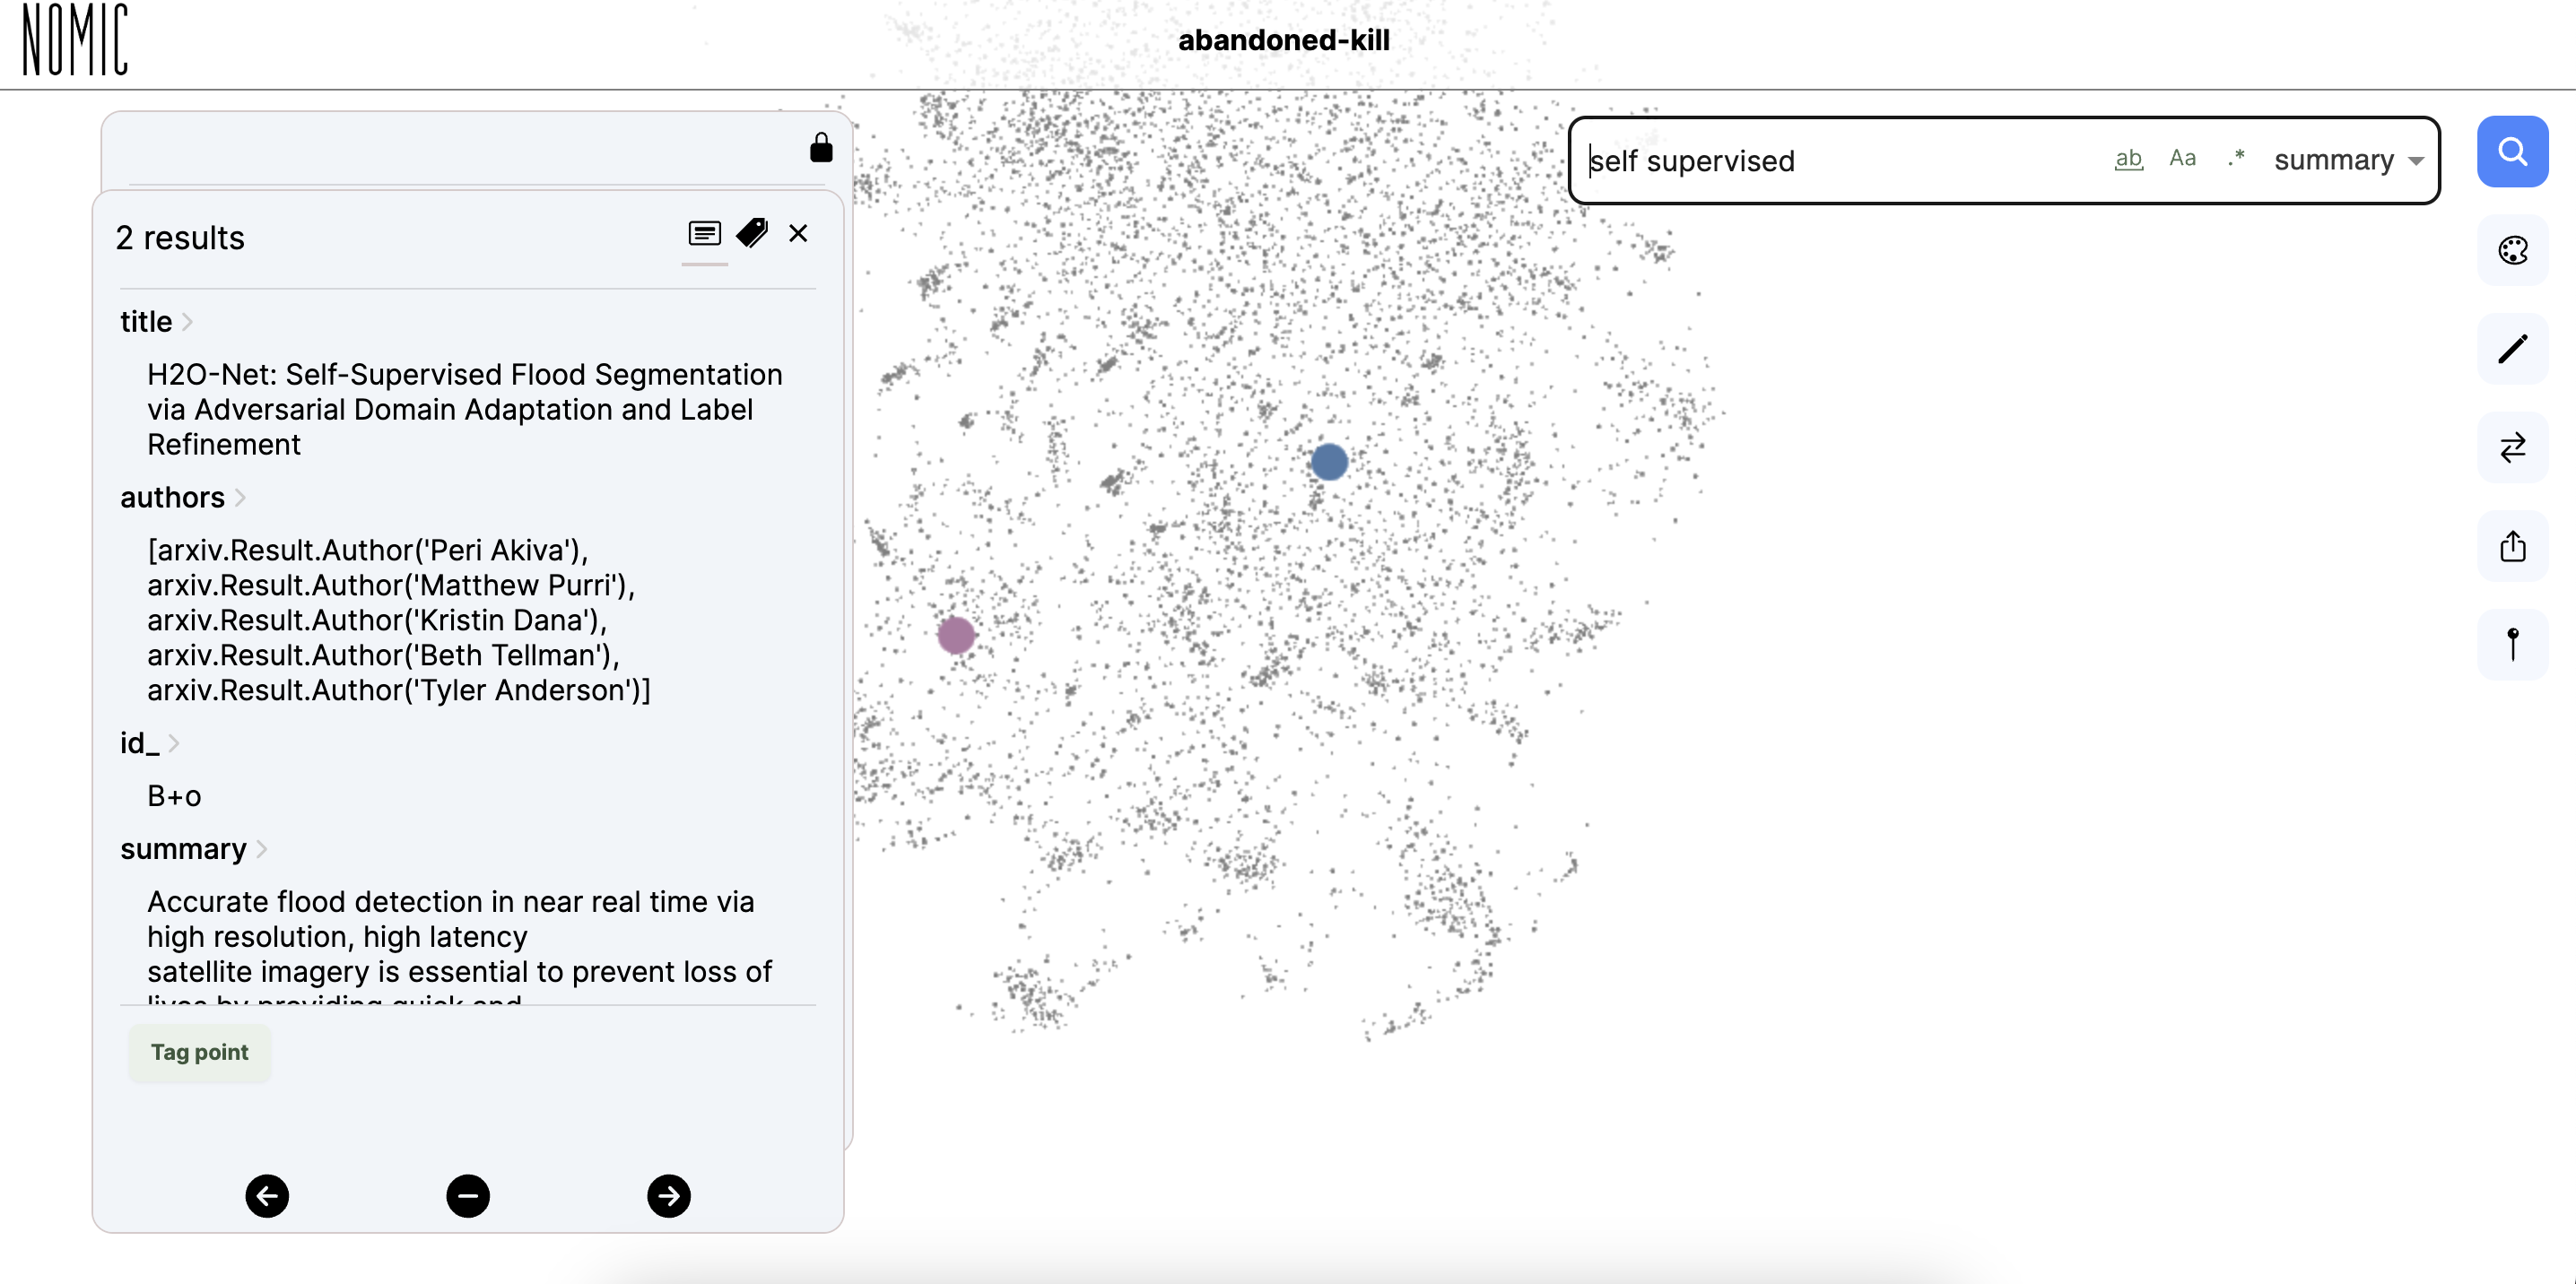